# **1. Introduction** <a class="anchor" id="1"></a>

## **1.2. Import packages**

In [1]:
# Remember: library imports are ALWAYS at the top of the script, no exceptions!
import math
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from math import ceil
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas_profiling import ProfileReport
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
# Feature selection
from sklearn.feature_selection import VarianceThreshold

from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances

from sklearn import random_projection

from scipy.cluster.hierarchy import dendrogram

#Functions
import OurFunctions as func

## **1.3. Import data**

In [2]:
data = pd.read_csv('data/donors.csv',index_col='CONTROLN', low_memory=False)
print("The data set has total %d records and %d features" %data.shape)

The data set has total 95412 records and 475 features


# **2. Pre-processing data:** <a class="anchor" id="1"></a>
After conducting **Exploratory Data Analysis (Appendix 1)** for 475 features of the original data set, we have listed out the most significant features that we consider to be important for the clustering task.  
Thus, from now, we will continue with these selected features:

In [3]:
# Import the database we create for selecting the features:
features_list = pd.read_csv('Selected_Features.csv',index_col=0)
features_list.head()

FeaturesName                                    Description  \
Index                                                               
1          ODATEDW        Origin Date. Date of donor's first gift   
2          OSOURCE                                  Origin Source   
3            TCODE                               Donor title code   
4            STATE  State abbreviation (a nominal/symbolic field)   
5              ZIP             Zipcode (a nominal/symbolic field)   

              Category SubCategory Phuc Henrique Lorenzo Selected  
Index                                                              
1      Characteristics         NaN  NaN        x     NaN        x  
2      Characteristics         NaN  NaN        x     NaN        x  
3      Characteristics         NaN  NaN        x     NaN        x  
4      Characteristics         NaN  NaN        x     NaN        x  
5      Characteristics         NaN  NaN        x     NaN        x

In [4]:
# Get the selected features
selected_feats = features_list[features_list['Selected'] == 'x']['FeaturesName']
df = data[selected_feats].copy()
df.dtypes

ODATEDW     object
OSOURCE     object
TCODE        int64
STATE       object
ZIP         object
             ...  
RFA_2A      object
MDMAUD_R    object
MDMAUD_F    object
MDMAUD_A    object
GEOCODE2    object
Length: 177, dtype: object

In [5]:
features_list.drop(['Phuc','Henrique','Lorenzo'],axis=1,inplace=True)

# **Feature engineering:** <a class="anchor" id="1"></a>


## 2.1. Getting the Age of every donor:
We notice that there is one feature called DOB - Day of Birth of the donors, so we thought it would we useful to generate the age of the donors as one feature. The donor's age will be measured at the time the donor received the most recent promotion which is recorded in 'MAXADATE' feature.

In [6]:
#converting the DOB column to datetime type
parsed_dates = pd.to_datetime(df.DOB, format='%Y-%m-%d' , errors='coerce') #errors='coerce' meant to return NaN in case of exception
df['DOB'] = parsed_dates
df['MAXADATE'] = pd.to_datetime(df['MAXADATE'], format='%Y-%m-%d' , errors='coerce')
# Getting the age of every donor today
df['AGE'] = ((df['MAXADATE'] - df['DOB']).dt.days/365).floordiv(other=1).astype('int',errors='ignore')

# Append new features to the feature list
feats = pd.DataFrame([['AGE', "Age of the donor","Characteristics","","x"]],
                    columns=features_list.columns)
features_list= features_list.append(feats,ignore_index=True)

# Now, drop de DOB column as it is no longer useful
df.drop('DOB',inplace=True,axis = 1)

## **2.2. Converting binary features of mailing activity:** <a class="anchor" id="1"></a>
There are features containing binary information but they are not in the right data type for processing, so we convert them to binary type

In [7]:
#Replace the values for booleans
df.loc[:, 'COLLECT1':'PLATES'] = df.loc[:, 'COLLECT1':'PLATES'].replace(' ',0)
df.loc[:, 'COLLECT1':'PLATES'] = df.loc[:, 'COLLECT1':'PLATES'].replace('Y',1)
df.loc[:, 'COLLECT1':'PLATES'].head()

COLLECT1  VETERANS  BIBLE  CATLG  HOMEE  PETS  CDPLAY  STEREO  \
CONTROLN                                                                  
95515            0         0      0      0      0     0       0       0   
148535           0         0      0      0      0     0       0       0   
15078            0         0      0      0      0     0       0       0   
172556           0         0      0      0      0     0       0       0   
7112             0         0      1      1      0     0       0       1   

          PCOWNERS  PHOTO  CRAFTS  FISHER  GARDENIN  BOATS  WALKER  KIDSTUFF  \
CONTROLN                                                                       
95515            0      0       0       0         0      0       0         0   
148535           0      0       0       0         0      0       0         0   
15078            0      0       0       0         0      0       0         0   
172556           0      0       0       0         0      0       0         0   
7112             0      0       1       0         1      0       1         0   

          CARDS  PLATES  
CONTROLN                 
95515         0       0  
148535        0       0  
15078         0       0  
172556        0       0  
7112          1       0

## **2.3. Generate RFA status of the each donor before they are considered to be Lapsed Donor:** <a class="anchor" id="1"></a>
Because all the donors which is investigated in this dataset is all Lapsed Donors as the date of the lasted promotion, so we will not able to undestand the 'Recency' charateristics if we only consider the most recent code of the donor (all 'Lapsed').  

Therefore, we thought it would be interesting if we get the most recent type of code of each donor before they are considered to become Lapsed Donors

We will consider the data in features **Donor's RFA status as of XXXX promotion date (XXXX is from 'RFA_3'to 'RFA_24')**

In [8]:
# Replace the blank values with NaN value
df.loc[:,'RFA_3':'RFA_24'] = df.loc[:,'RFA_3':'RFA_24'].replace({' ' : np.NaN})
# Find the second most recent type of a donor by the left-most available values from RFA_3 to RFA_24
df['RFA_USEDTO'] = df.loc[:,'RFA_3':'RFA_24'].fillna(method = 'bfill',axis = 1)['RFA_3']
# Renerate R, F, A features
df['RFA_USEDTO_R'] = df['RFA_USEDTO'].apply(lambda x: str(x)[0])
df['RFA_USEDTO_F'] = df['RFA_USEDTO'].apply(lambda x: str(x)[1])
df['RFA_USEDTO_A'] = df['RFA_USEDTO'].apply(lambda x: str(x)[2])

# Add to the selected features list
feats = pd.DataFrame([['RFA_USEDTO_R', "Recency code of the previous status of the donor","Promotion and Gift","","x" ],
                    ['RFA_USEDTO_F', "Frequency code of the previous status of the donor","Promotion and Gift","","x"], 
                    ['RFA_USEDTO_A', "Amount code of the previous status of the donor","Promotion and Gift","","x"]],
                    columns=features_list.columns)
features_list= features_list.append(feats,ignore_index=True)

# Now drop the features that is no longer useful
df.drop(labels='RFA_USEDTO',axis=1,inplace = True, errors='ignore')
# Check for the result
df.loc[:,'RFA_USEDTO_R':'RFA_USEDTO_A'].head()

RFA_USEDTO_R RFA_USEDTO_F RFA_USEDTO_A
CONTROLN                                       
95515               S            4            E
148535              A            2            G
15078               S            4            E
172556              S            4            E
7112                A            2            F

In [9]:
# Drop the RFA status of donor as they are no longer useful
df.drop(labels=df.loc[:,'RFA_3':'RFA_24'].columns,axis=1,inplace=True,errors='ignore')

In [10]:
selected_feats = features_list.loc[features_list['FeaturesName'].isin(df.columns),:]
# Summary by category
pd.DataFrame(selected_feats.groupby('Category')['FeaturesName'].count())

FeaturesName
Category                        
Characteristics               23
Interests                     19
Mail response                 14
Neighborhood                  75
Promotion and Gift            27

# **3. Data cleaning:** <a class="anchor" id="1"></a>
## 3.1. Check for features interpretability:
In this section, we will access the ability to interpret the feature based on its description, number of unique values and nulls values.  
We also try to engineer some features for better interpretation

### 3.1.1. Characteristics features:

In [11]:
char_feats = selected_feats[selected_feats['Category'] == 'Characteristics']['FeaturesName']
selected_feats[selected_feats['Category'] == 'Characteristics']

FeaturesName                                        Description  \
0        ODATEDW            Origin Date. Date of donor's first gift   
1        OSOURCE                                      Origin Source   
2          TCODE                                   Donor title code   
3          STATE      State abbreviation (a nominal/symbolic field)   
4            ZIP                 Zipcode (a nominal/symbolic field)   
5       MAILCODE                                          Mail Code   
13        MDMAUD                        The Major Donor Matrix code   
14        DOMAIN  DOMAIN/Cluster code. A nominal or symbolic field.   
15      HOMEOWNR                                    Home Owner Flag   
16       CHILD03                       Presence of Children age 0-3   
17       CHILD07                       Presence of Childern age 4-7   
18       CHILD12                      Presence of Childern age 8-12   
19       CHILD18                     Presence of Childern age 13-18   
20       NUMCHLD                                 NUMBER OF CHILDREN   
21        INCOME                                   HOUSEHOLD INCOME   
22        GENDER                                             Gender   
23       WEALTH1                                      Wealth Rating   
24           HIT               MOR Flag # HIT (Mail Order Response)   
49         MAJOR                              Major ($$) Donor Flag   
50       WEALTH2                                      Wealth Rating   
51       GEOCODE  Geo Cluster Code indicating the level geograph...   
474     GEOCODE2                                   County Size Code   
475          AGE                                   Age of the donor   

            Category SubCategory Selected  
0    Characteristics         NaN        x  
1    Characteristics         NaN        x  
2    Characteristics         NaN        x  
3    Characteristics         NaN        x  
4    Characteristics         NaN        x  
5    Characteristics         NaN        x  
13   Characteristics         NaN        x  
14   Characteristics         NaN        x  
15   Characteristics         NaN        x  
16   Characteristics         NaN        x  
17   Characteristics         NaN        x  
18   Characteristics         NaN        x  
19   Characteristics         NaN        x  
20   Characteristics         NaN        x  
21   Characteristics         NaN        x  
22   Characteristics         NaN        x  
23   Characteristics         NaN        x  
24   Characteristics         NaN        x  
49   Characteristics         NaN        x  
50   Characteristics         NaN        x  
51   Characteristics         NaN        x  
474  Characteristics         NaN        x  
475  Characteristics                    x

There are some columns contain missing values but in different type of format rather than NaN format. Thus, in this section, we will replace them with numpy.NaN values for better processing:

In [12]:
df[char_feats].isin([' ']).sum(axis = 0).sort_values(ascending=False)

MAJOR       95118
CHILD03     94266
MAILCODE    94013
CHILD07     93846
CHILD12     93601
CHILD18     92565
GEOCODE     80168
HOMEOWNR    22228
GENDER       2957
DOMAIN       2316
OSOURCE       928
GEOCODE2      187
MDMAUD          0
TCODE           0
STATE           0
ZIP             0
AGE             0
NUMCHLD         0
INCOME          0
WEALTH1         0
HIT             0
WEALTH2         0
ODATEDW         0
dtype: int64

### OSOURCE

In [13]:
#droping invalid values for column OSOURCE
df = df[df.OSOURCE != ' ']

### ZIP

In [14]:
#clean all the ZIP values with hifén
df.ZIP = df.ZIP.replace("-","", regex=True)

### MAILCODE

In [15]:
#Convert Mailcode options to binary
df.loc[:, 'MAILCODE'] = df.loc[:, 'MAILCODE'].replace(' ',1)
df.loc[:, 'MAILCODE'] = df.loc[:, 'MAILCODE'].replace('B',0)

### DOMAIN

In [16]:
#droping invalid values for column DOMAIN
df = df[df.DOMAIN != ' ']

### HOMEOWNR

In [17]:
#replace NaN values for Unknown 
df.HOMEOWNR.replace(' ','U',inplace=True)

### GENDER

In [18]:
#checking all the values for the Gender
#M = Male
#F = Female
#U = Unknown
#J = Joint Account
print(df['GENDER'].unique())

#replacing unknown values to 'U'
df['GENDER'].replace(' ','U',inplace=True)
df['GENDER'].replace('A','U',inplace=True)
df['GENDER'].replace('C','U',inplace=True)

#checking the difference
print(df['GENDER'].unique())

['F' 'M' ' ' 'C' 'U' 'J' 'A']
['F' 'M' 'U' 'J']


In [19]:
func.unique_check_categorical(df[char_feats], 0.9)

MDMAUD , percentage of top unique value = 99.77 %
CHILD03 , percentage of top unique value = 98.79 %
CHILD07 , percentage of top unique value = 98.34 %
CHILD12 , percentage of top unique value = 98.08 %
CHILD18 , percentage of top unique value = 96.97 %
MAJOR , percentage of top unique value = 99.77 %


In [20]:
#columns are not interesting and have lots of null values
df.drop(['MAILCODE','MDMAUD','CHILD03','CHILD07','CHILD12','CHILD18','MAJOR'],inplace=True,axis = 1)
# Update the seleted features list
selected_feats = func.update_selected_feats_list(df, features_list)
char_feats = selected_feats[selected_feats['Category'] == 'Characteristics']['FeaturesName']

In [21]:
#Check for Nulls values
print(df[char_feats].isna().sum().sort_values(ascending=False))

#too many null values for NUMCHLD and GEOCODE so we will drop these columns
df.drop(['NUMCHLD','GEOCODE'],inplace=True,axis = 1,errors='ignore')
# Update the seleted features list
selected_feats = func.update_selected_feats_list(df, features_list)
char_feats = selected_feats[selected_feats['Category'] == 'Characteristics']['FeaturesName']

NUMCHLD     80165
WEALTH1     43235
WEALTH2     42402
AGE         22816
INCOME      20502
GEOCODE2      117
GEOCODE         0
HIT             0
GENDER          0
HOMEOWNR        0
DOMAIN          0
ZIP             0
STATE           0
TCODE           0
OSOURCE         0
ODATEDW         0
dtype: int64


### 3.1.2 Interests features

In [22]:
# selected features
selected_feats[selected_feats['Category'] == 'Interests']

FeaturesName                     Description   Category SubCategory  \
52     COLLECT1               COLLECTABLE (Y/N)  Interests         NaN   
53     VETERANS                  VETERANS (Y/N)  Interests         NaN   
54        BIBLE             BIBLE READING (Y/N)  Interests         NaN   
55        CATLG           SHOP BY CATALOG (Y/N)  Interests         NaN   
56        HOMEE            WORK FROM HOME (Y/N)  Interests         NaN   
57         PETS            HOUSEHOLD PETS (Y/N)  Interests         NaN   
58       CDPLAY          CD PLAYER OWNERS (Y/N)  Interests         NaN   
59       STEREO   STEREO/RECORDS/TAPES/CD (Y/N)  Interests         NaN   
60     PCOWNERS            HOME PC OWNERS/USERS  Interests         NaN   
61        PHOTO               PHOTOGRAPHY (Y/N)  Interests         NaN   
62       CRAFTS                    CRAFTS (Y/N)  Interests         NaN   
63       FISHER                   FISHING (Y/N)  Interests         NaN   
64     GARDENIN                 GARDENING (Y/N)  Interests         NaN   
65        BOATS             POWER BOATING (Y/N)  Interests         NaN   
66       WALKER           WALK FOR HEALTH (Y/N)  Interests         NaN   
67     KIDSTUFF  BUYS CHILDREN'S PRODUCTS (Y/N)  Interests         NaN   
68        CARDS    STATIONARY/CARDS BUYER (Y/N)  Interests         NaN   
69       PLATES           PLATE COLLECTOR (Y/N)  Interests         NaN   
70      LIFESRC          LIFE STYLE DATA SOURCE  Interests         NaN   

   Selected  
52        x  
53        x  
54        x  
55        x  
56        x  
57        x  
58        x  
59        x  
60        x  
61        x  
62        x  
63        x  
64        x  
65        x  
66        x  
67        x  
68        x  
69        x  
70        x

In [23]:
interests_feats = selected_feats[selected_feats['Category'] == 'Interests']['FeaturesName']

In [24]:
df[interests_feats].isin([' ']).sum(axis = 0)

COLLECT1        0
VETERANS        0
BIBLE           0
CATLG           0
HOMEE           0
PETS            0
CDPLAY          0
STEREO          0
PCOWNERS        0
PHOTO           0
CRAFTS          0
FISHER          0
GARDENIN        0
BOATS           0
WALKER          0
KIDSTUFF        0
CARDS           0
PLATES          0
LIFESRC     52140
dtype: int64

In [25]:
# We have blank space only in the variable LIFESRC (LIFE STYLE DATA SOURCE)
df['LIFESRC'] = df['LIFESRC'].replace(' ', np.NaN)

In [26]:
#Check for unique values
func.unique_check_categorical(df[interests_feats], 0.6)

There is no column has too high percentage of a value


In [27]:
func.unique_check_numerical(df[interests_feats], 0.9)

['COLLECT1',
 'BIBLE',
 'CATLG',
 'HOMEE',
 'PHOTO',
 'CRAFTS',
 'FISHER',
 'BOATS',
 'KIDSTUFF',
 'CARDS',
 'PLATES']

In [28]:
func.check_value_counts(df[interests_feats])

COLLECT1
0    87217
1     5057
Name: COLLECT1, dtype: int64
-------------------
VETERANS
0    82202
1    10072
Name: VETERANS, dtype: int64
-------------------
BIBLE
0    83663
1     8611
Name: BIBLE, dtype: int64
-------------------
CATLG
0    84652
1     7622
Name: CATLG, dtype: int64
-------------------
HOMEE
0    91411
1      863
Name: HOMEE, dtype: int64
-------------------
PETS
0    78361
1    13913
Name: PETS, dtype: int64
-------------------
CDPLAY
0    80375
1    11899
Name: CDPLAY, dtype: int64
-------------------
STEREO
0    79871
1    12403
Name: STEREO, dtype: int64
-------------------
PCOWNERS
0    82071
1    10203
Name: PCOWNERS, dtype: int64
-------------------
PHOTO
0    87642
1     4632
Name: PHOTO, dtype: int64
-------------------
CRAFTS
0    84332
1     7942
Name: CRAFTS, dtype: int64
-------------------
FISHER
0    85315
1     6959
Name: FISHER, dtype: int64
-------------------
GARDENIN
0    79259
1    13015
Name: GARDENIN, dtype: int64
-------------------
BOATS
0 

In [29]:
# dropping the variables with too many unique values = 0. It means that the interest is not that common, so probably no useful to detect clusters
df = df.drop(columns=['COLLECT1','BIBLE','CATLG','HOMEE','PHOTO','CRAFTS', 'FISHER','BOATS','KIDSTUFF','CARDS','PLATES'])

In [30]:
# updating the interest's list
interests_feats = ['VETERANS', 'PETS','CDPLAY', 'STEREO', 'PCOWNERS','GARDENIN', 'WALKER', 'LIFESRC']

Check for null values

In [31]:
df[interests_feats].isna().sum()

VETERANS        0
PETS            0
CDPLAY          0
STEREO          0
PCOWNERS        0
GARDENIN        0
WALKER          0
LIFESRC     52140
dtype: int64

In [32]:
# We have many Nan values for the variable LIFESRC, so we decide to drop also this variable
df = df.drop(columns='LIFESRC')
interests_feats.remove('LIFESRC')

### 3.1.3 Mail response features

In [33]:
# selected features
mail_feats = selected_feats[selected_feats['Category'] == 'Mail response']['FeaturesName']
selected_feats[selected_feats['Category'] == 'Mail response']

FeaturesName               Description       Category SubCategory Selected
25      MBCRAFT           Buy Craft Hobby  Mail response         NaN        x
26     MBGARDEN             Buy Gardening  Mail response         NaN        x
27      MBBOOKS                 Buy Books  Mail response         NaN        x
28     MBCOLECT          Buy Collectables  Mail response         NaN        x
29      MAGFAML   Buy General Family Mags  Mail response         NaN        x
30       MAGFEM           Buy Female Mags  Mail response         NaN        x
31      MAGMALE           Buy Sports Mags  Mail response         NaN        x
32     PUBGARDN            Gardening Pubs  Mail response         NaN        x
33     PUBCULIN             Culinary Pubs  Mail response         NaN        x
34      PUBHLTH               Health Pubs  Mail response         NaN        x
35     PUBDOITY       Do It Yourself Pubs  Mail response         NaN        x
36     PUBNEWFN       News / Finance Pubs  Mail response         NaN        x
37     PUBPHOTO          Photography Pubs  Mail response         NaN        x
38       PUBOPP  Opportunity Seekers Pubs  Mail response         NaN        x

In [34]:
func.check_value_counts(df[mail_feats])

MBCRAFT
0.0    36508
1.0     3439
2.0     1050
3.0      210
4.0       32
5.0        2
6.0        1
Name: MBCRAFT, dtype: int64
-------------------
MBGARDEN
0.0    39037
1.0     1995
2.0      185
3.0       22
4.0        3
Name: MBGARDEN, dtype: int64
-------------------
MBBOOKS
0.0    20677
1.0    10020
2.0     4524
3.0     2394
4.0     1420
5.0      864
6.0      519
7.0      316
9.0      314
8.0      194
Name: MBBOOKS, dtype: int64
-------------------
MBCOLECT
0.0    39050
1.0     1760
2.0      308
3.0       50
4.0       11
5.0        4
6.0        1
Name: MBCOLECT, dtype: int64
-------------------
MAGFAML
0.0    28832
1.0     8239
2.0     2775
3.0      978
4.0      319
5.0       74
6.0       17
7.0        7
9.0        1
Name: MAGFAML, dtype: int64
-------------------
MAGFEM
0.0    36666
1.0     4004
2.0      514
3.0       51
4.0        6
5.0        1
Name: MAGFEM, dtype: int64
-------------------
MAGMALE
0.0    38783
1.0     2231
2.0      193
3.0       31
4.0        4
Name: MAGMALE, dt

In [35]:
#Check for null values
df[mail_feats].isna().sum()

MBCRAFT     51032
MBGARDEN    51032
MBBOOKS     51032
MBCOLECT    51090
MAGFAML     51032
MAGFEM      51032
MAGMALE     51032
PUBGARDN    51032
PUBCULIN    51032
PUBHLTH     51032
PUBDOITY    51032
PUBNEWFN    51032
PUBPHOTO    51032
PUBOPP      51032
dtype: int64

In [36]:
# The percentages of the Nan are the same for all the variables, it means that we have the information of the mail reply only for a subset of our dataset
print(round(df[mail_feats].isna().sum()[0] / len(df) * 100, 2), '% of data dont have the information for all those variables')
#We will not use them to do the clusters and only analyse that after that

55.3 % of data dont have the information for all those variables


### 3.1.4 Neighborhood

In [37]:
Neigh_feats = selected_feats[selected_feats['Category'] == 'Neighborhood']['FeaturesName']
# selected features
selected_feats[selected_feats['Category'] == 'Neighborhood']

FeaturesName                                   Description      Category  \
72        POP901                             Number of Persons  Neighborhood   
75       POP90C1          Percent Population in Urbanized Area  Neighborhood   
76       POP90C2     Percent Population Outside Urbanized Area  Neighborhood   
77       POP90C3          Percent Population Inside Rural Area  Neighborhood   
78       POP90C4                                  Percent Male  Neighborhood   
..           ...                                           ...           ...   
302         AFC4                Percent Adult Veterans Age 16+  Neighborhood   
305          VC1              Percent Vietnam Veterans Age 16+  Neighborhood   
307          VC3                  Percent WW2 Veterans Age 16+  Neighborhood   
308          VC4  Percent Veterans Serving After May 1995 Only  Neighborhood   
324        POBC1                          Percent Foreign Born  Neighborhood   

    SubCategory Selected  
72   Population        x  
75   Population        x  
76   Population        x  
77   Population        x  
78   Population        x  
..          ...      ...  
302    Military        x  
305    Military        x  
307    Military        x  
308    Military        x  
324    Ancestry        x  

[75 rows x 5 columns]

In [38]:
df[Neigh_feats].isnull().sum().sort_values(ascending=False)

DMA       117
ADI       117
MSA       117
POBC1       0
HU3         0
         ... 
LFC4        0
OCC1        0
OCC2        0
OCC3        0
POP901      0
Length: 75, dtype: int64

In [39]:
#dropping highly correlated columns
func.correlation_check(df[Neigh_feats])

Columns having high correlation: ['LFC4']


### 3.1.4. Promotion and Gift features:

In [40]:
PG_feats = selected_feats[selected_feats['Category'] == 'Promotion and Gift']['FeaturesName']
# selected features
selected_feats[selected_feats['Category'] == 'Promotion and Gift']

FeaturesName                                        Description  \
404      CARDPROM     Lifetime number of card promotions received to   
405      MAXADATE     Date of the most recent promotion received (in   
406       NUMPROM     Lifetime number of promotions received to date   
407      CARDPM12     Number of card promotions received in the last   
408      NUMPRM12       Number of promotions received in the last 12   
453      RAMNTALL            Dollar amount of lifetime gifts to date   
454      NGIFTALL                   Number of lifetime gifts to date   
455      CARDGIFT  Number of lifetime gifts to card promotions to...   
456      MINRAMNT             Dollar amount of smallest gift to date   
457      MINRDATE     Date associated with the smallest gift to date   
458      MAXRAMNT              Dollar amount of largest gift to date   
459      MAXRDATE      Date associated with the largest gift to date   
460      LASTGIFT                  Dollar amount of most recent gift   
461      LASTDATE          Date associated with the most recent gift   
462      FISTDATE                                 Date of first gift   
463      NEXTDATE                                Date of second gift   
464       TIMELAG     Number of months between first and second gift   
465       AVGGIFT             Average dollar amount of gifts to date   
468        RFA_2R                             Recency code for RFA_2   
469        RFA_2F                           Frequency code for RFA_2   
470        RFA_2A                     Donation Amount code for RFA_2   
471      MDMAUD_R                            Recency code for MDMAUD   
472      MDMAUD_F                           Frequecy code for MDMAUD   
473      MDMAUD_A                    Donation Amount code for MDMAUD   
476  RFA_USEDTO_R   Recency code of the previous status of the donor   
477  RFA_USEDTO_F  Frequency code of the previous status of the d...   
478  RFA_USEDTO_A    Amount code of the previous status of the donor   

               Category SubCategory Selected  
404  Promotion and Gift     Summary        x  
405  Promotion and Gift     Summary        x  
406  Promotion and Gift     Summary        x  
407  Promotion and Gift     Summary        x  
408  Promotion and Gift     Summary        x  
453  Promotion and Gift     Summary        x  
454  Promotion and Gift     Summary        x  
455  Promotion and Gift     Summary        x  
456  Promotion and Gift     Summary        x  
457  Promotion and Gift     Summary        x  
458  Promotion and Gift     Summary        x  
459  Promotion and Gift     Summary        x  
460  Promotion and Gift     Summary        x  
461  Promotion and Gift     Summary        x  
462  Promotion and Gift     Summary        x  
463  Promotion and Gift     Summary        x  
464  Promotion and Gift     Summary        x  
465  Promotion and Gift     Summary        x  
468  Promotion and Gift     Summary        x  
469  Promotion and Gift     Summary        x  
470  Promotion and Gift     Summary        x  
471  Promotion and Gift     Summary        x  
472  Promotion and Gift     Summary        x  
473  Promotion and Gift     Summary        x  
476  Promotion and Gift                    x  
477  Promotion and Gift                    x  
478  Promotion and Gift                    x

There are 4 date-time features that we can assume that they will not have much interpretation power for clustering.  
Those features are: **'MINRDATE', 'MAXRDATE', 'NEXTDATE' and 'TIMELAG'**.  

Thus, we decided to drop them:

In [41]:
# Remove un-relevant features
df = df.drop(columns=['MINRDATE','MAXRDATE','NEXTDATE','TIMELAG'],errors='ignore')

The remaining date-time features are 'MAXADATE', 'LASTDATE' and 'FISTDATE'. These features are useful to generate two important features in RFM (Recency, Frequency and Monetary) analysis which are Recency and Frequency.  

The 2 new features to generate are:
- Time in days since the last promotion and the last gift from the donor: 'RECENCY' = 'MAXADATE' - 'LASTDATE'  
- Time in days since the last promotion and the first gift from the donor: 'LIFETIME' = 'MAXADATE' - 'FISTDATE' 

In [42]:
# convert data to datetime 
df['MAXADATE'] = pd.to_datetime(df['MAXADATE'])
df['LASTDATE'] = pd.to_datetime(df['LASTDATE'])
df['FISTDATE'] = pd.to_datetime(df['FISTDATE'])
# measure the recency and lifetime of donors
df['RECENCY'] = (df['MAXADATE'] - df['LASTDATE'])/pd.to_timedelta(1, unit='D')
df['LIFETIME'] = (df['MAXADATE'] - df['FISTDATE'])/pd.to_timedelta(1, unit='D')

# Add new features to the metadata
feats = pd.DataFrame([['RECENCY', "Time in days since the last promotion and the last gift from the donor","Promotion and Gift","","x" ],
                    ['LIFETIME', "Time in days since the last promotion and the first gift from the donor","Promotion and Gift","","x"]], 
                    columns=selected_feats.columns)
features_list= features_list.append(feats,ignore_index=True)
                      
# Then we drop the datetime columns:
df = df.drop(columns=['MAXADATE','FISTDATE','LASTDATE'],errors='ignore')

# Update the seleted features list
selected_feats = func.update_selected_feats_list(df, features_list)
PG_feats = selected_feats[selected_feats['Category'] == 'Promotion and Gift']['FeaturesName']

In [43]:
#Check for unique values
func.unique_check_categorical(df[PG_feats], 0.9)

RFA_2R , percentage of top unique value = 100.00 %
MDMAUD_R , percentage of top unique value = 99.77 %
MDMAUD_F , percentage of top unique value = 99.77 %
MDMAUD_A , percentage of top unique value = 99.77 %


We can clearly see that features **'RFA_2R', 'MDMAUD_R', 'MDMAUD_F' and 'MDMAUD_A'** having only 1 values for mostly all of their records, thus they are considered redundant in this cluster analysis

In [44]:
# Drop these redundant columns
df = df.drop(columns=['RFA_2R', 'MDMAUD_R', 'MDMAUD_F','MDMAUD_A'],errors='ignore')
# Update the seleted features list
selected_feats = func.update_selected_feats_list(df, features_list)
PG_feats = selected_feats[selected_feats['Category'] == 'Promotion and Gift']['FeaturesName']

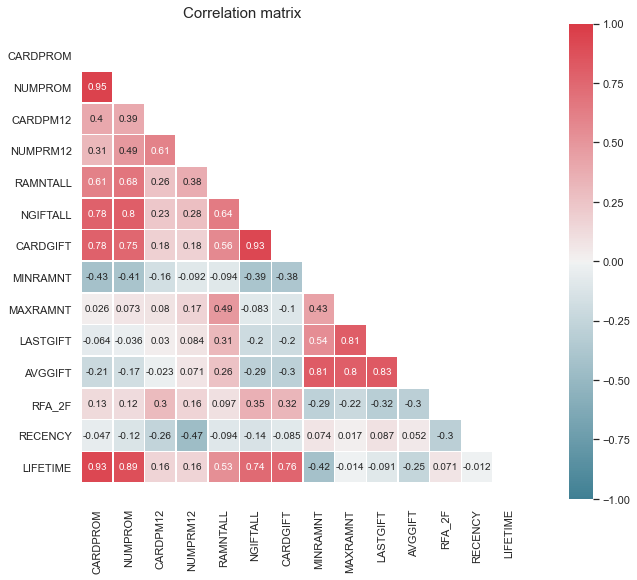

In [45]:
#Check for correlation
func.corrheatmap(df[PG_feats])

In [46]:
func.correlation_check(df[PG_feats])

Columns having high correlation: ['NUMPROM', 'CARDGIFT', 'LIFETIME']


In [47]:
# Drop these redundant columns
df = df.drop(columns=['NUMPROM', 'CARDGIFT', 'LIFETIME'])
# Update the seleted features list
selected_feats = func.update_selected_feats_list(df, features_list)
PG_feats = selected_feats[selected_feats['Category'] == 'Promotion and Gift']['FeaturesName']

## 3.2. Check for outliers:

<AxesSubplot:>

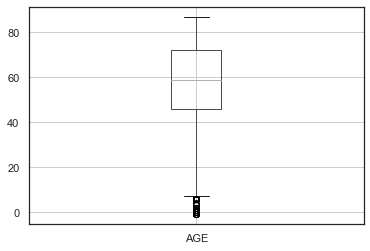

In [48]:
# Check for the box plot and distribution
df.boxplot(['AGE'])
# Here we can see that we have outliers, we will access this in the up coming session

In [49]:
df = func.IQR_OutlierRemover(df,'AGE',2)

Percentage of data kept after removing outliers: 1.0


<AxesSubplot:>

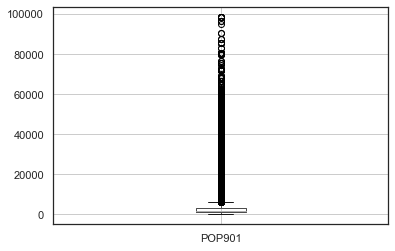

In [50]:
# Check for the box plot and distribution
df.boxplot(['POP901'])
# Here we can see that we have outliers, we will access this in the up coming session

In [51]:
df = func.IQR_OutlierRemover(df,'POP901',12.5)

Percentage of data kept after removing outliers: 0.9885


<AxesSubplot:>

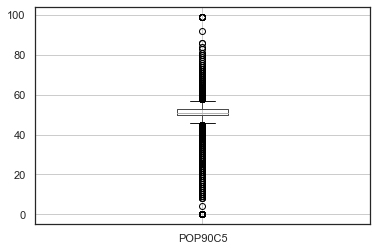

In [52]:
# Check for the box plot and distribution
df.boxplot(['POP90C5'])
# Here we can see that we have outliers, we will access this in the up coming session

In [53]:
df = func.IQR_OutlierRemover(df,'POP90C5',5)

Percentage of data kept after removing outliers: 0.9872


<AxesSubplot:>

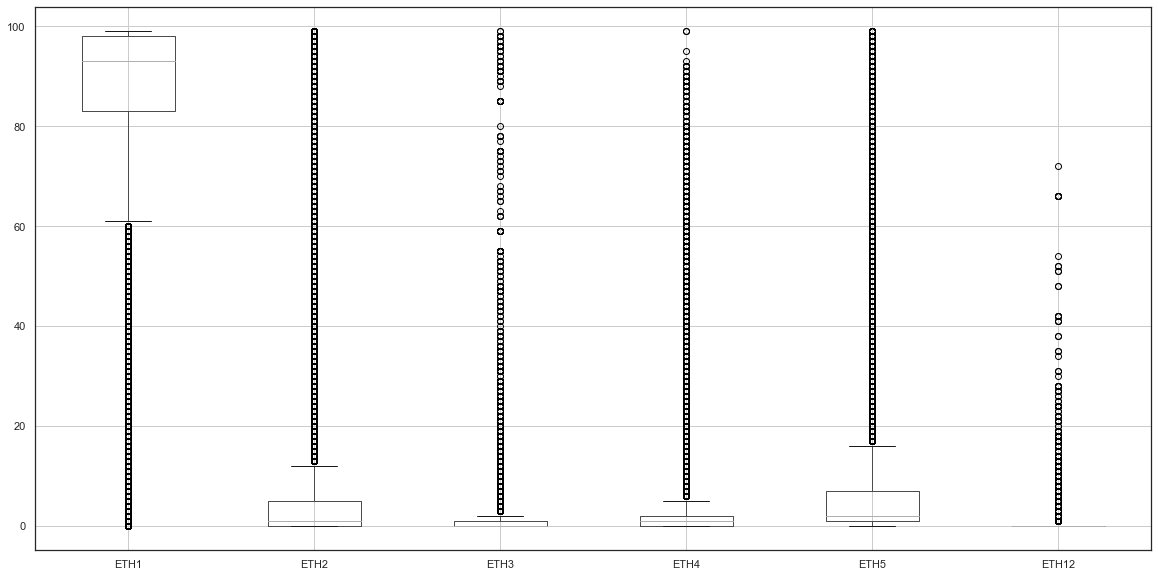

In [54]:
df.boxplot(column=['ETH1','ETH2','ETH3','ETH4','ETH5','ETH12'], figsize=(20,10))

In [63]:
df['ETH12'].describe()

count    90039.000000
mean         0.068204
std          1.179036
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         72.000000
Name: ETH12, dtype: float64

In [64]:
#i will drop this column based on its description
df.drop('ETH12', axis=1,inplace=True)

In [55]:
#Removing Outlier of some columns without getting rid of lots of data
df = func.IQR_OutlierRemover(df,'ETH1',5)
df = func.IQR_OutlierRemover(df,'ETH2',13)
df = func.IQR_OutlierRemover(df,'ETH3',10)
df = func.IQR_OutlierRemover(df,'ETH4',13)
df = func.IQR_OutlierRemover(df,'ETH5',12.5)

Percentage of data kept after removing outliers: 0.985
Percentage of data kept after removing outliers: 0.99
Percentage of data kept after removing outliers: 0.9907
Percentage of data kept after removing outliers: 0.9921
Percentage of data kept after removing outliers: 0.9928


## 3.3. Handling with Null Values using KNN 

In [56]:
#checking if we have all-null rows
print('Initial Shape:',df.shape)
print('Shape without all-null rows',df.dropna(how='all').shape)
#we don't have so we don't remove nothing

Initial Shape: (85679, 125)
Shape without all-null rows (85679, 125)


In [57]:
df.dtypes

ODATEDW          object
OSOURCE          object
TCODE             int64
STATE            object
ZIP              object
                 ...   
AGE             float64
RFA_USEDTO_R     object
RFA_USEDTO_F     object
RFA_USEDTO_A     object
RECENCY         float64
Length: 125, dtype: object

In [63]:
df.RFA_USEDTO_F = df.RFA_USEDTO_F.astype('int64')
df.ZIP=df.ZIP.astype('int64')
df.ODATEDW = df.ODATEDW.astype('datetime64')

In [64]:
#we will not use them for clustering
df.drop(mail_feats,axis=1,inplace=True)

### Characteristics

In [65]:
#get metric and caterocial for characteristics
char_metric = df[char_feats].select_dtypes(include=['float64','int64']).columns.tolist()
char_nonmetric = df[char_feats].select_dtypes(include=['object','datetime64']).columns.tolist()

In [66]:
df[char_nonmetric]

ODATEDW OSOURCE STATE DOMAIN HOMEOWNR GENDER GEOCODE2
CONTROLN                                                         
95515    2009-01-01     GRI    IL     T2        U      F        C
148535   2014-01-01     BOA    CA     S1        H      M        A
15078    2010-01-01     AMH    NC     R2        U      M        C
172556   2007-01-01     BRY    CA     R2        U      F        C
47784    2014-01-01     CWR    AL     T2        U      U        C
...             ...     ...   ...    ...      ...    ...      ...
184568   2016-01-01     ASE    AK     C2        U      M        C
122706   2016-01-01     DCD    TX     C1        H      M        A
189641   2015-01-01     MBC    MI     C3        U      M        B
4693     2006-01-01     PRV    CA     C1        H      F        A
185114   2008-01-01     MCC    NC     C1        U      F        C

[85679 rows x 7 columns]

In [67]:
df[char_metric]

TCODE    ZIP  INCOME  WEALTH1  HIT  WEALTH2   AGE
CONTROLN                                                   
95515         0  61081     NaN      NaN    0      5.0  59.0
148535        1  91326     6.0      9.0   16      9.0  45.0
15078         1  27017     3.0      1.0    2      1.0   NaN
172556        0  95953     1.0      4.0    2      0.0  69.0
47784         0  35603     NaN      NaN    0      NaN   NaN
...         ...    ...     ...      ...  ...      ...   ...
184568        1  99504     NaN      NaN    0      NaN   NaN
122706        1  77379     7.0      9.0    1      NaN  47.0
189641        1  48910     NaN      NaN    0      NaN  59.0
4693          0  91320     7.0      NaN    0      7.0  56.0
185114        2  28409     5.0      8.0    3      8.0  79.0

[85679 rows x 7 columns]

In [130]:
#KNNImputer - only works for numerical variables
from sklearn.impute import KNNImputer

#Characteristics
knn_imputer = KNNImputer(weights="uniform",copy=False)

df[char_metric] = knn_imputer.fit_transform(df[char_metric])

In [131]:
df[char_metric]

TCODE      ZIP  INCOME  WEALTH1   HIT  WEALTH2   AGE
CONTROLN                                                      
95515       0.0  61081.0     3.6      4.6   0.0      5.0  59.0
148535      1.0  91326.0     6.0      9.0  16.0      9.0  45.0
15078       1.0  27017.0     3.0      1.0   2.0      1.0  56.2
172556      0.0  95953.0     1.0      4.0   2.0      0.0  69.0
47784       0.0  35603.0     4.0      5.4   0.0      8.4  45.6
...         ...      ...     ...      ...   ...      ...   ...
184568      1.0  99504.0     4.2      7.0   0.0      6.8  56.4
122706      1.0  77379.0     7.0      9.0   1.0      8.0  47.0
189641      1.0  48910.0     3.6      5.2   0.0      7.0  59.0
4693        0.0  91320.0     7.0      7.2   0.0      7.0  56.0
185114      2.0  28409.0     5.0      8.0   3.0      8.0  79.0

[87729 rows x 7 columns]